In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %%
username = 'recipesadmin'
password = 'HomeUG1000'
host = 'recipesdb.cpamk8qk2wid.us-east-2.rds.amazonaws.com'
port = '5432'
database = 'postgres'

In [6]:
engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}')

df = pd.read_sql_table("recipes_processed", con=engine)
df.head()

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,...,Time_Difference,Ingredient_Count,Unique_Ingredient_Count,Contains_Healthy,Num_Steps,Complexity_Score,Popularity_Score,Ingredients_Calories_Interaction,Ingredients_Protein_Interaction,Ingredients_Fat_Interaction
0,Carina's Tofu-Vegetable Kebabs,PT20M,PT24H,PT24H20M,This dish is best prepared a day in advance to...,Soy/Tofu,"c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.5,2.0,...,-1420,14,14,True,13,173.0,4.943755,7505.4,410.2,336.0
1,Best Blackbottom Pie,PT2H,PT20M,PT2H20M,Make and share this Best Blackbottom Pie recip...,Pie,"c(""1 1/4"", ""1/4"", ""6"", ""1/3"", ""1/4"", ""1/4"", ""2...","c(""graham cracker crumbs"", ""sugar"", ""butter"", ...",1.0,1.0,...,100,13,11,False,8,35.0,0.693147,5692.7,91.0,250.9
2,Carrot Cake,PT50M,PT45M,PT1H35M,This is one of the few recipes my husband ever...,Dessert,"c(""3"", ""4"", ""1 1/4"", ""2"", ""2"", ""2"", ""2"", ""1"", ...","c(""carrots"", ""eggs"", ""white sugar"", ""all-purpo...",5.0,17.0,...,5,14,14,False,5,28.5,14.451859,7316.4,70.0,379.4
3,Almond Pound Cake,PT1H,PT15M,PT1H15M,Make and share this Almond Pound Cake recipe f...,Dessert,"c(""2/3"", ""3 1/2"", ""1 1/4"", ""4"", ""2 1/4"", ""5"", ...","c(""butter"", ""almond paste"", ""sugar"", ""eggs"", ""...",4.5,3.0,...,45,8,8,False,7,22.5,6.238325,3268.0,55.2,143.2
4,Blueberry Buttertarts,PT25M,PT15M,PT40M,Make and share this Blueberry Buttertarts reci...,Dessert,"c(""12"", ""1"", ""1/2"", ""1"", ""3/4"", ""1/3"", ""1"", ""1...","c(""egg"", ""corn syrup"", ""lemon juice"", ""vanilla...",5.0,4.0,...,10,7,7,True,6,17.0,8.047190,2365.3,29.4,128.8


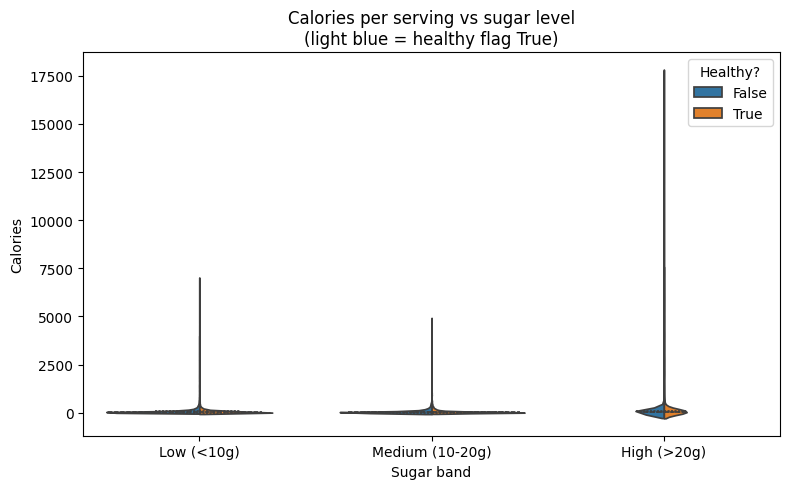

In [7]:
df['SugarBand'] = pd.cut(df['SugarContent'],
                         bins=[-np.inf,10,20,np.inf],
                         labels=['Low (<10g)','Medium (10-20g)','High (>20g)'])

plt.figure(figsize=(8,5))
sns.violinplot(x='SugarBand', y='Calories_per_Serving',
               hue='Contains_Healthy', data=df,
               split=True, inner='quartile')
plt.title('Calories per serving vs sugar level\n(light blue = healthy flag True)')
plt.xlabel('Sugar band'); plt.ylabel('Calories')
plt.legend(title='Healthy?')
plt.tight_layout(); plt.show()

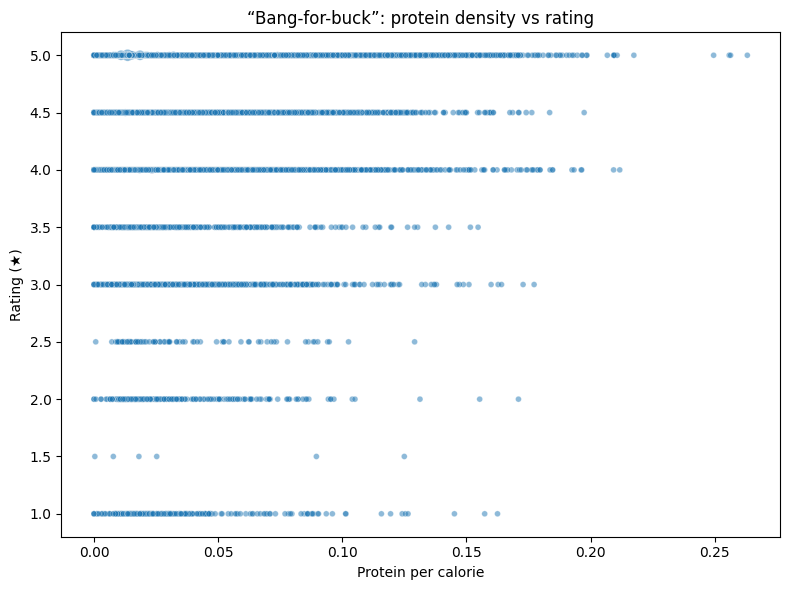

In [8]:
df['ProteinDensity'] = df['Protein_per_Serving'] / df['Calories_per_Serving']
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='ProteinDensity', y='AggregatedRating',
                size='ReviewCount', alpha=.5, legend=False)
plt.title('“Bang-for-buck”: protein density vs rating')
plt.xlabel('Protein per calorie'); plt.ylabel('Rating (★)')
plt.tight_layout(); plt.show()

In [9]:

import plotly.express as px


category_ratings = df.groupby('RecipeCategory')['AggregatedRating'].mean()


treemap_data = df.groupby('RecipeCategory').size().reset_index(name='count')
treemap_data['AggregatedRating'] = treemap_data['RecipeCategory'].map(category_ratings)


fig = px.treemap(treemap_data,
                 path=['RecipeCategory'],
                 values='count',
                 color='AggregatedRating',
                 color_continuous_scale='RdBu',
                 title='Recipe Categories by Count and Mean Aggregated Rating')
fig.show()


In [ ]:
# prompt:  Show flows from workout goals (weight loss, muscle gain, maintenance) to recipe categories, then to the single most common ingredient in each category.

import pandas as pd

# Sample data (replace with your actual data)
data = {
    'WorkoutGoal': ['weight loss', 'weight loss', 'muscle gain', 'muscle gain', 'maintenance', 'maintenance'],
    'RecipeCategory': ['Salads', 'Low-Carb', 'High-Protein', 'High-Protein', 'Balanced', 'Balanced'],
    'Ingredient': ['Lettuce', 'Chicken', 'Chicken', 'Eggs', 'Salmon', 'Quinoa']
}
df = pd.DataFrame(data)

# Group by WorkoutGoal and RecipeCategory, then find the most frequent ingredient
def most_common_ingredient(x):
    return x.value_counts().index[0]

result = df.groupby(['WorkoutGoal', 'RecipeCategory'])['Ingredient'].agg(most_common_ingredient).reset_index()

result


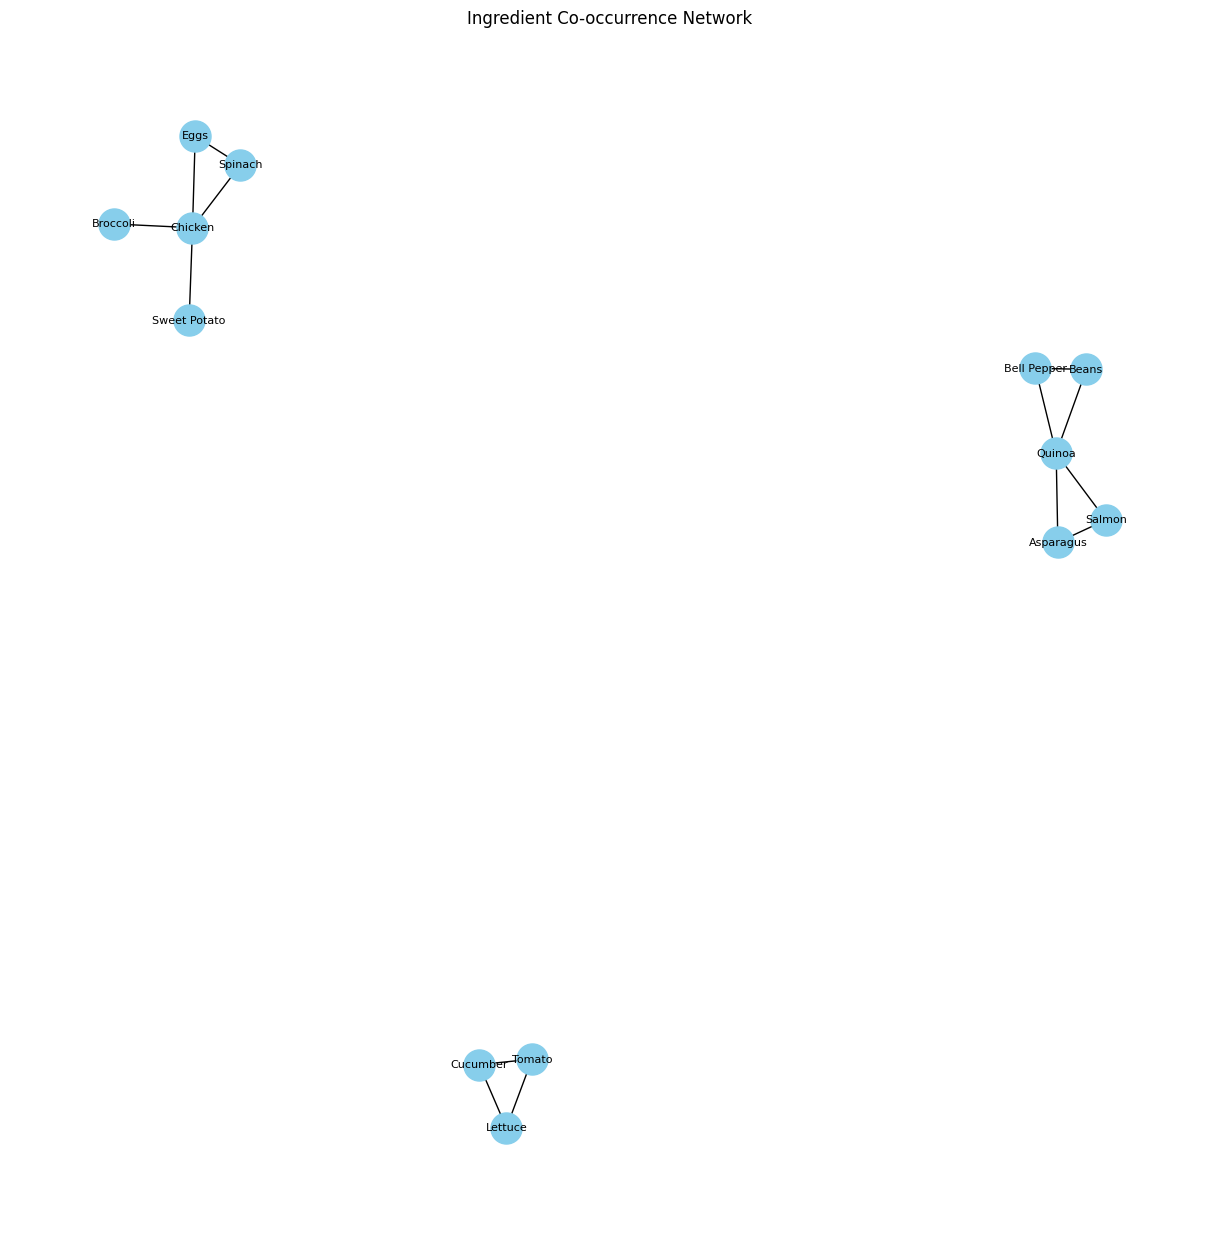

In [ ]:
# prompt: Ingredient-level word cloud / network
# Chart: Co-occurrence network graph, where nodes = ingredients and edge thickness = how often two ingredients appear together in the same recipe.
# Why: Surfaces flavour pairings and could power recommendation (“people who cooked x also cooked y”).
# How: – explode your ingredients column (if it’s a list-of-strings) into rows, build a co-occurrence matrix with itertools.combinations, and visualise with NetworkX + matplotlib or Plotly for hover labels.

import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data = {
    'RecipeCategory': ['Salads', 'Low-Carb', 'High-Protein', 'High-Protein', 'Balanced', 'Balanced'],
    'Ingredients': [['Lettuce', 'Tomato', 'Cucumber'], ['Chicken', 'Broccoli'], ['Chicken', 'Eggs', 'Spinach'], ['Chicken', 'Sweet Potato'], ['Salmon', 'Quinoa', 'Asparagus'], ['Quinoa', 'Beans', 'Bell Pepper']]
}
df = pd.DataFrame(data)

# Explode the Ingredients column
df_exploded = df.explode('Ingredients')

# Create co-occurrence matrix
ingredient_pairs = list(itertools.combinations(df_exploded['Ingredients'].unique(), 2))
cooccurrence_matrix = {}
for pair in ingredient_pairs:
    cooccurrence_matrix[pair] = 0

for index, row in df.iterrows():
    ingredients = row['Ingredients']
    for pair in itertools.combinations(ingredients, 2):
      if pair in cooccurrence_matrix:
        cooccurrence_matrix[pair] +=1

# Create a graph
graph = nx.Graph()

for pair, count in cooccurrence_matrix.items():
    if count > 0:  # Add edges only if ingredients co-occur
        graph.add_edge(pair[0], pair[1], weight=count)


# Visualize the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph)  # You can try different layouts
nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8, width=[graph[u][v]['weight'] for u,v in graph.edges()])
plt.title("Ingredient Co-occurrence Network")
plt.show()
